In [1]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

# Load the image Super resolution dataset

In [2]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 256
high_img = []
path = '/kaggle/input/image-super-resolution/dataset/Raw Data/high_res'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
    if i == '855.jpg':
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        high_img.append(img_to_array(img))


low_img = []
path = '/kaggle/input/image-super-resolution/dataset/Raw Data/low_res'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
     if i == '855.jpg':
        break
     else: 
        img = cv2.imread(path + '/'+i,1)

        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        low_img.append(img_to_array(img))

100%|██████████| 855/855 [00:11<00:00, 77.20it/s]


# let's visualize the data

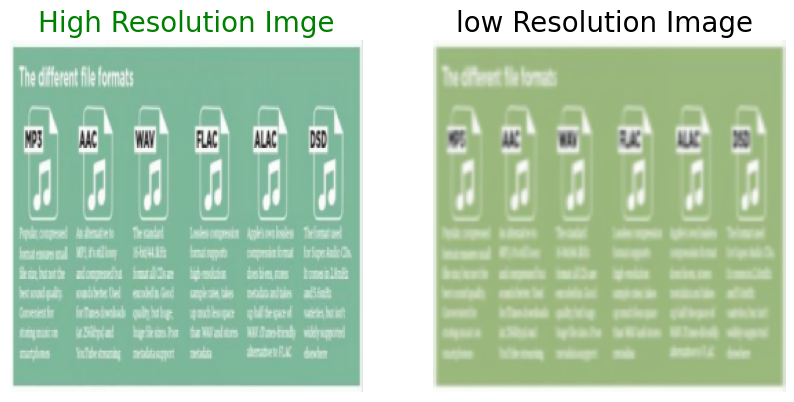

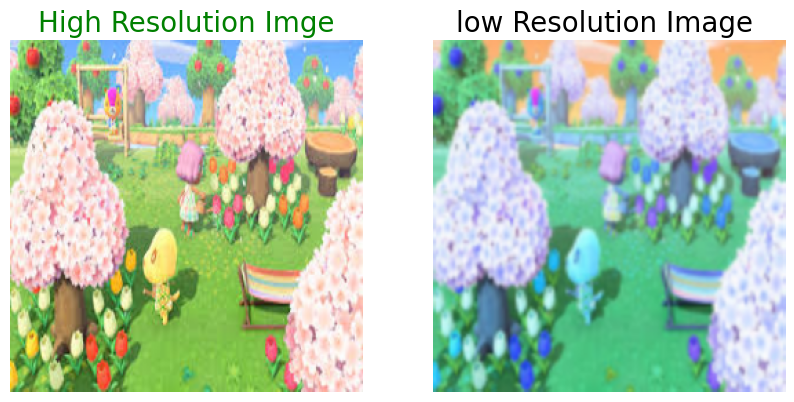

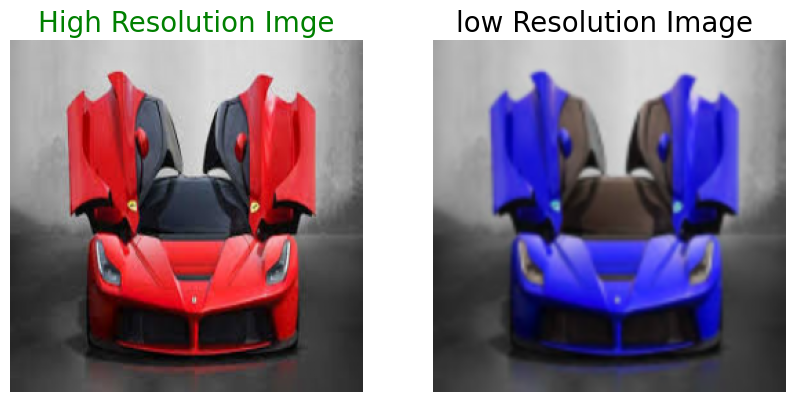

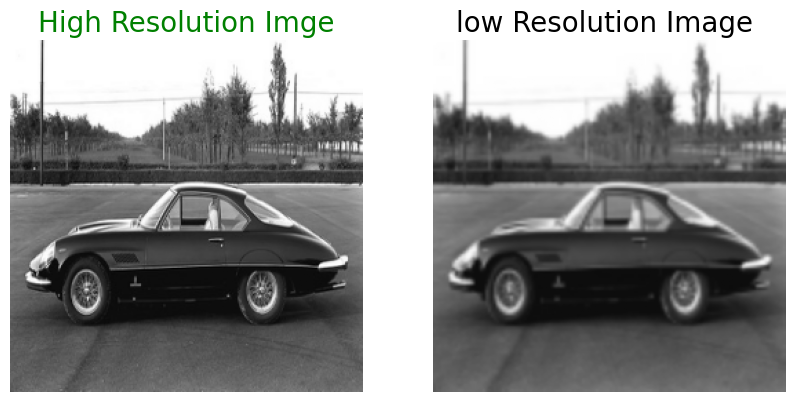

In [3]:
for i in range(4):
    a = np.random.randint(0,855)
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.title('High Resolution Imge', color = 'green', fontsize = 20)
    plt.imshow(high_img[a])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title('low Resolution Image ', color = 'black', fontsize = 20)
    plt.imshow(low_img[a])
    plt.axis('off')

In [ ]:
# Divide the high-resolution and low-resolution images into training, validation, and testing sets
# Training set: First 700 images
train_high_image = high_img[:700]  # Take the first 700 high-resolution images
train_low_image = low_img[:700]    # Take the first 700 low-resolution images

# Reshape the training data to the format (num_images, height, width, channels)
train_high_image = np.reshape(train_high_image, (len(train_high_image), SIZE, SIZE, 3))
train_low_image = np.reshape(train_low_image, (len(train_low_image), SIZE, SIZE, 3))

# Validation set: Next 130 images (700 to 830)
validation_high_image = high_img[700:830]  # Take images from index 700 to 829 for validation
validation_low_image = low_img[700:830]    # Take corresponding low-resolution images

# Reshape the validation data
validation_high_image = np.reshape(validation_high_image, (len(validation_high_image), SIZE, SIZE, 3))
validation_low_image = np.reshape(validation_low_image, (len(validation_low_image), SIZE, SIZE, 3))

# Test set: Remaining images (index 830 onwards)
test_high_image = high_img[830:]  # Take images from index 830 onward for testing
test_low_image = low_img[830:]    # Take corresponding low-resolution images

# Reshape the test data
test_high_image = np.reshape(test_high_image, (len(test_high_image), SIZE, SIZE, 3))
test_low_image = np.reshape(test_low_image, (len(test_low_image), SIZE, SIZE, 3))

# Print the shapes of the datasets
print("Shape of training images:", train_high_image.shape)
print("Shape of test images:", test_high_image.shape)
print("Shape of validation images:", validation_high_image.shape)


# Model Construction:

### Inputs: Accepts RGB images of shape SIZE × SIZE × 3.
### Downsampling (Encoder): Sequential blocks that reduce the spatial size while increasing feature depth.
### Upsampling (Decoder): Sequential blocks that restore spatial size while merging features from the encoder path.
### Output: Final Conv2D layer refines and reconstructs the output image with 3 channels (RGB).

In [ ]:
from keras import layers

# Function to create a downsampling block
def down(filters, kernel_size, apply_batch_normalization=True):
    # Sequential block for downsampling
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters, kernel_size, padding='same', strides=2))  # Halve spatial size
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())  # Stabilize training
    downsample.add(keras.layers.LeakyReLU())  # Add activation function
    return downsample

# Function to create an upsampling block
def up(filters, kernel_size, dropout=False):
    # Sequential block for upsampling
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size, padding='same', strides=2))  # Double spatial size
    if dropout:
        upsample.add(layers.Dropout(0.2))  # Apply dropout for regularization
    upsample.add(keras.layers.LeakyReLU())  # Add activation function
    return upsample

# Function to define the full model
def model():
    inputs = layers.Input(shape=[SIZE, SIZE, 3])  # Input layer for RGB images of size (SIZE, SIZE)
    
    # Downsampling blocks (encoder path)
    d1 = down(128, (3, 3), False)(inputs)
    d2 = down(128, (3, 3), False)(d1)
    d3 = down(256, (3, 3), True)(d2)
    d4 = down(512, (3, 3), True)(d3)
    d5 = down(512, (3, 3), True)(d4)
    
    # Upsampling blocks (decoder path)
    u1 = up(512, (3, 3), False)(d5)  # Upsample and concatenate with corresponding downsampled output
    u1 = layers.concatenate([u1, d4])
    u2 = up(256, (3, 3), False)(u1)
    u2 = layers.concatenate([u2, d3])
    u3 = up(128, (3, 3), False)(u2)
    u3 = layers.concatenate([u3, d2])
    u4 = up(128, (3, 3), False)(u3)
    u4 = layers.concatenate([u4, d1])
    
    # Final upsampling and reconstruction
    u5 = up(3, (3, 3), False)(u4)
    u5 = layers.concatenate([u5, inputs])  # Optionally combine with original input for refinement
    output = layers.Conv2D(3, (2, 2), strides=1, padding='same')(u5)  # Output RGB image
    
    return tf.keras.Model(inputs=inputs, outputs=output)

# Instantiate the model and print its summary
model = model()
model.summary()


# compile

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

# Fitting Model